To perform hyperparameter optimization, use this script !<br>
Data preprocessing :
<br>
Two data sources will be imported <br>
-"AIS_weather_h_rename_copy.csv" will be used to replace the information for true current direction and true wind direction <br>
-The resulting dataframe will be merged with the dataframe from the "AIS_weather_H_ok2_copy.csv" <br>
-The data of the journey between Ronne and Sassnitz will be omitted <br>
-The threshold for the ships manouvering speed will be 5kt (Abebe) <br>

In [108]:
import pandas as pd
from matplotlib import pyplot
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import pickle
import joblib

dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
dfmain = dfmain[dfmain['LAT'] > 55.04 ]

dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
dfpre = dfpre[dfpre['LAT'] > 55.04 ]



In [109]:
dfpre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7453 entries, 0 to 7995
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Time                                  7453 non-null   datetime64[ns]
 1   LON                                   7453 non-null   float64       
 2   LAT                                   7453 non-null   float64       
 3   Eastward wind                         7453 non-null   float64       
 4   Northward wind                        7453 non-null   float64       
 5   Temperature above oceans              7453 non-null   float64       
 6   Air density above oceans              7337 non-null   float64       
 7   Max wave height                       6274 non-null   float64       
 8   Swell direction                       6274 non-null   float64       
 9   Wind wave direction                   6274 non-null   float64       
 10  

In [110]:
dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.head(n=5)

,eastwind,northwind,eastcurrent,northcurrent,sog,cog
0,2.267688,6.741482,0.113690,0.044994,0.0,358.9
1,1.782681,6.410275,0.113690,0.044994,0.0,358.9
2,1.154659,6.385135,0.083984,0.054000,0.0,358.9
3,0.348801,6.094659,0.083984,0.054000,0.0,358.9
4,-0.593128,6.153186,0.083984,0.054000,0.0,358.9


In [111]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

KNNImputer(n_neighbors=50)

In [112]:
x_pre = imputer.transform(dfpre)

In [113]:
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [114]:
# Calculate the True North wind direction

condwind = [(dfpre['eastwind']>0) & (dfpre['northwind']<0),
            (dfpre['eastwind']<0) & (dfpre['northwind']>0),
            (dfpre['eastwind']>0) & (dfpre['northwind']>0)]

choicewind = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"])))]

dfpre["True North Wind Direction"] = np.select(condwind, choicewind, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))))

In [115]:
# Calculate the True North current direction

condcurr = [(dfpre['eastcurrent']<0) & (dfpre['northcurrent']>0),
            (dfpre['eastcurrent']>0) & (dfpre['northcurrent']<0),
            (dfpre['eastcurrent']<0) & (dfpre['northcurrent']<0)]

choicecurr = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"])))]

dfpre["True North Current Direction"] = np.select(condcurr, choicecurr, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))))

In [116]:
dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [117]:
# dfpre["True North Wind Direction"] = 180 +  np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))

In [118]:
# dfpre["True North Current Direction"] = np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))

In [119]:
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog,True North Wind Direction,True North Current Direction,Current Speed,Wind Speed
count,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000
mean,1.976344,0.379926,0.019228,0.004214,8.870751,242.699284,198.585961,150.634332,0.096788,6.513813
std,5.296850,4.429899,0.089903,0.074041,8.619512,108.555287,92.310964,100.306234,0.067697,3.048934
min,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241,0.052191,0.102997,0.000735,0.193221
25%,-1.756650,-2.534061,-0.021486,-0.033055,0.000000,124.116508,139.632096,73.919853,0.047447,4.149883
50%,2.294543,0.385690,0.025485,0.003718,6.953578,283.216008,205.028650,121.289202,0.079148,6.285080
75%,5.838650,3.339456,0.062644,0.039626,18.014436,346.200000,275.302728,227.423990,0.128444,8.525129
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115,359.892603,359.958291,0.525174,16.760001


In [120]:
dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [121]:
dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [122]:
df = pd.concat([dfmain,dfpre],axis=1)
df.head()

,Unnamed: 0,Time,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,True North Wind Direction,True North Current Direction,Current Speed,Wind Speed
0,0,2021-01-01 00:00:00,14.689663,55.098452,277.311035,1.259323,1.893614,4.818881,3.818459,4.154329,...,174.0,155.408180,105.591753,22.854050,22.749664,22.610062,251.408180,68.408246,0.122270,7.112664
1,1,2021-01-01 01:00:00,14.689659,55.098451,277.328369,1.259985,1.752303,4.755800,3.470216,4.130580,...,174.0,158.458891,105.591753,26.122772,19.152008,22.209274,254.458891,68.408246,0.122270,6.653538
2,2,2021-01-01 02:00:00,14.689648,55.098468,277.390625,1.260244,1.619775,4.645083,3.259682,4.083755,...,174.0,163.749663,116.740448,28.498383,12.424912,20.857971,259.749663,57.259552,0.099846,6.488697
3,3,2021-01-01 03:00:00,14.689646,55.098471,277.411377,1.260148,1.518736,4.588384,3.177906,4.010502,...,174.0,170.724504,116.740448,29.956985,6.725922,18.732071,266.724504,57.259552,0.099846,6.104632
4,4,2021-01-01 04:00:00,14.689644,55.098462,277.430664,1.260634,1.455034,4.528841,3.281654,3.913362,...,174.0,179.505940,116.740448,34.486298,3.761627,15.731430,174.494060,57.259552,0.099846,6.181707


In [123]:
# SOG threshold according to Abebe
df = df[df['SOG'] > 5 ]

In [124]:
# Exclude data for the month of June to check the model's forecasting performance 
dfdate6 = df[df['Time'].dt.strftime('%Y-%m') == '2021-06']
df = df[df['Time'].dt.strftime('%Y-%m') != '2021-06']

In [125]:
# Temporary export
# df.to_csv("AIS_sog_threshold.csv")

In [126]:
# Temporary export
# df.to_csv("AIS_impute_check.csv")

Data Analysis before modelling 

In [127]:
df_ship = df.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
                    'Surface pressure','Width','Length'],axis=1)
df_ship.head(n=5)

,Temperature above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,Combined wind waves and swell height,Swell height,Wind wave height,Draught,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,True North Wind Direction,True North Current Direction,Current Speed,Wind Speed
8,276.900391,1.661038,4.291309,3.667458,3.757862,279.699585,0.865413,0.323892,0.801956,5.017723,...,269.900574,91.133175,143.029898,82.454986,91.138748,90.495209,268.966251,52.930471,0.104064,7.648595
9,276.705566,1.501637,4.187211,3.145607,3.803910,279.820312,0.785675,0.452440,0.578049,5.019207,...,300.130435,68.884377,96.351303,134.548587,115.015200,120.971331,260.985188,36.481737,0.104050,6.700397
10,276.309815,1.235528,4.012717,2.120399,3.819602,NaN,0.654636,0.556525,0.236435,5.019664,...,230.117302,129.989203,174.697284,59.296837,47.905998,52.498604,269.893495,44.814586,0.092759,4.089472
11,276.399902,1.204397,4.020009,2.090308,3.820546,NaN,0.638782,0.555405,0.226181,5.019009,...,178.653615,170.879672,107.951765,8.221531,10.314571,1.236454,262.226057,70.701850,0.093128,3.821501
12,277.134033,1.275907,4.095175,3.029945,3.815268,279.820312,0.674081,0.598373,0.263031,5.020452,...,125.446296,102.327505,72.665715,47.977150,68.470208,54.270195,246.881208,52.780582,0.086621,5.479353


In [128]:
df_ship2 = df_ship.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [129]:
df_ship2 = df_ship2[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

In [130]:
# Scaling script if necessary

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df_ship2 = pd.DataFrame(scaler.fit_transform(df_ship2),columns=df_ship2.columns)


In [131]:
# import matplotlib.pyplot as plt
# plt.rcParams.update(plt.rcParamsDefault)
# df_ship2.hist(bins=50,figsize=(20,15))
# plt.show()

In [132]:
# df_ship2['curspeed'].hist(bins=50)
# plt.show()

In [133]:
# hhstats = df_ship2.describe()
# print(hhstats)

Feature Selection

In [134]:
# corr_matrix = df_ship2.corr()
# print(corr_matrix["sog"])

In [135]:
# dfship_corr = df_ship2.drop(df_ship2.columns[[0,5,15,16,17,18,19,20,21]],axis=1)
# dfship_corr.head()

In [136]:
# def correlation_heatmap(df,fontsize):
#     correlations = df.corr()

#     fig, ax = plt.subplots(figsize=(10,10))
#     sns.set(font_scale = fontsize)
#     sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
#                 square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
#     plt.show();
    
# correlation_heatmap(df_ship2,0.5)

Scientific Justification of HCF:

According to Bitner Gregersen, the wind wave swell height is equal to the square root of the square of swell wave and wind wave. Therefore SWH and WWH is to be dropped.<br>
According to Mori, through wave spectrum, the maximum wave height can be approximated, therefore max wave height can be dropped as well <br>
According to Torsetshaugen, The type of dominating wave (Wind wave/Swell) can be predicted from the significant through an equation which include the significant wave height and a certain threshold, therefore, it is decided that the wind wave period, swell period and consequently the true wind wave direction and true swell direction is to be dropped.

In [137]:
df_ship2 = df_ship2.drop(['waveheight','swellheight','windwaveheight',
                        'windwaveperiod','swellperiod',
                        'truewindwavedir','trueswelldir',
                        'truenorthcurrentdir','truenorthwinddir'],axis=1)
# correlation_heatmap(df_ship2,.6)

In [138]:
# dfship_corrftf = dfship_corr.drop(['waveheight','swellheight','windwaveheight'],axis=1)

# correlation_heatmap(dfship_corrftf,1)

In [139]:
# import matplotlib.pyplot as plt
# plt.rcParams.update(plt.rcParamsDefault)
# df_ship2.hist(bins=50,figsize=(20,15))
# plt.show()

In [140]:
# from pandas.plotting import scatter_matrix

# # attributes = df_ship2.columns

# scatter_matrix(dfship_corrftf,figsize=(25,25))

In [141]:
# df_ship2.info()

Imputing using KNN so that the Random Forest Regressor may function <br>
RFR cannot accept nan values <br>
Imputed data is then transformed

In [142]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(df_ship2)


KNNImputer(n_neighbors=50)

In [143]:
X = imputer.transform(df_ship2)

In [144]:
df_ship2tr = pd.DataFrame(X, columns=df_ship2.columns, index=df_ship2.index)

In [145]:
print(df_ship2tr.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3506 entries, 8 to 7976
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     3506 non-null   float64
 1   waveperiod           3506 non-null   float64
 2   surftemp             3506 non-null   float64
 3   windwaveswellheight  3506 non-null   float64
 4   draught              3506 non-null   float64
 5   sog                  3506 non-null   float64
 6   cog                  3506 non-null   float64
 7   heading              3506 non-null   float64
 8   windspeed            3506 non-null   float64
 9   curspeed             3506 non-null   float64
 10  truewinddir          3506 non-null   float64
 11  truecurrentdir       3506 non-null   float64
 12  truewavedir          3506 non-null   float64
dtypes: float64(13)
memory usage: 383.5 KB
None


Data Split for training and test data

In [146]:
# Implement the Random forest, but first, data is to be split into training and validation data

from sklearn.model_selection import train_test_split

# Dropping some feature can be done here to (possibly) increase the model's performance 

x_train,x_test,y_train,y_test = train_test_split(df_ship2tr.drop(['sog']
                                                                 ,axis=1)
                                                                ,df_ship2tr.sog,test_size=0.2,random_state=42)


In [147]:
print("Amount of the x training dataset is:",len(x_train))

Amount of the x training dataset is: 2804


In [148]:
print("Amount of the test dataset is",len(x_test))

Amount of the test dataset is 702


Modelling using Random Forest Regressor 

In [149]:
from sklearn.ensemble import RandomForestRegressor
model_rfr_ftr = RandomForestRegressor(random_state=42)
model_rfr_ftr.fit(x_train,y_train)

RandomForestRegressor(random_state=42)

In [150]:
# from sklearn.ensemble import RandomForestRegressor
# model_rfr_ftr_hpo = RandomForestRegressor(n_estimators=230,
#                                   max_features=9,
#                                   random_state=42, 
#                                   )
# model_rfr_ftr_hpo.fit(x_train,y_train)

In [151]:
from sklearn.ensemble import RandomForestRegressor
model_rfr_ftr_hpov = RandomForestRegressor(n_estimators = 267,
                                            min_samples_split = 5,
                                            #min_samples_leaf = 2,
                                            max_features = 9,
                                            max_depth=136,
                                            bootstrap=False,
                                            random_state=42)
model_rfr_ftr_hpov.fit(x_train,y_train)

RandomForestRegressor(bootstrap=False, max_depth=136, max_features=9,
                      min_samples_split=5, n_estimators=267, random_state=42)

ETR TRAINING

In [152]:
from sklearn.ensemble import ExtraTreesRegressor

model_etr = ExtraTreesRegressor(random_state=42,
                                )
model_etr.fit(x_train,y_train)

ExtraTreesRegressor(random_state=42)

In [153]:
from sklearn.ensemble import ExtraTreesRegressor

model_etr_hpo = ExtraTreesRegressor(random_state=42,
                                n_estimators=400)
model_etr_hpo.fit(x_train,y_train)

ExtraTreesRegressor(n_estimators=400, random_state=42)

Modelling using Decision Tree Regressor

In [154]:
from sklearn.tree import DecisionTreeRegressor
model_dtr = DecisionTreeRegressor()
model_dtr.fit(x_train,y_train)

DecisionTreeRegressor()

In [155]:
from sklearn.tree import DecisionTreeRegressor
model_dtr_hpov = DecisionTreeRegressor(min_samples_split=10,
                                  min_samples_leaf=9,
                                  max_features=12,
                                  max_depth=90)
model_dtr_hpov.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=90, max_features=12, min_samples_leaf=9,
                      min_samples_split=10)

Modelling using Multiple Linear Regression

In [156]:
from sklearn import linear_model
model_mlr = linear_model.LinearRegression()
model_mlr.fit(x_train,y_train)

LinearRegression()

Model Evaluation

In [157]:
# import os
# from graphviz import Source
# from sklearn.tree import export_graphviz

# # Where to save the figures
# PROJECT_ROOT_DIR = "."
# CHAPTER_ID = "decision_trees"
# IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
# os.makedirs(IMAGES_PATH, exist_ok=True)

# def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
#     path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
#     print("Saving figure", fig_id)
#     if tight_layout:
#         plt.tight_layout()
#     plt.savefig(path, format=fig_extension, dpi=resolution)

# dot_data = export_graphviz(
#         model_dtr,
#         out_file=os.path.join(IMAGES_PATH, "regression_tree.dot"),
#         feature_names=x_train.columns.values.tolist(),
#         rounded=True,
#         filled=True
#     )

# Source.from_file(os.path.join(IMAGES_PATH, "regression_tree.dot"))

# # save_fig("reg_tree")
# # graph.format = "png"
# # graph.render("file_name")

In [158]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn import tree
# import graphviz

# dot_data = tree.export_graphviz(model_rfr_ftr.estimators_[5], 
#                   feature_names=x_train.columns.values.tolist(),  
#                 #   class_names=class_names,  
#                   filled=True, rounded=True,  
#                   special_characters=True,
#                    out_file=None,
#                    max_depth=3,
#                            )

# # os.system('dot -Tpng tree.dot -o tree.png')
# graph = graphviz.Source(dot_data)
# graph
# graph.format = "png"
# graph.render("file_name")


In [159]:
# from sklearn import tree

# def tree_visualization(width,height,model_type):
#     fn=x_train.columns
#     fig, axes = plt.subplots(figsize = (width,height), dpi=800)
#     tree.plot_tree(model_type.estimators_[0],
#                max_depth=3,
#                fontsize=8,
#                feature_names = fn);
#     plt.show()
#     #fig.savefig('rf_individualtree.png')

# tree_visualization(25,5,model_rfr_ftr)

In [160]:
# def model_importance(model_type):
#     mod_imp = model_type.feature_importances_
#     df_mod_imp = pd.DataFrame(mod_imp,index= x_train.columns,columns=["Importance"])
#     print(df_mod_imp)

# model_importance(model_rfr_ftr_hpo)

Evaluation of RFR

In [161]:
def predict_y(x_test,model_type):
    y_predicted = model_type.predict(x_test)
    return y_predicted

def display_scores(x_test,y_test,model_type):
    from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error
    y_predicted = model_type.predict(x_test)
    print("R^2 score (Indicate model fit. Best Score = 1):", model_type.score(x_test,y_test))
    print("Explained Variance EV (Indicate amount of variance in model. Best Score = 1):", explained_variance_score(y_test,y_predicted))
    print("Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0):", mean_absolute_error(y_test,y_predicted))
    print("Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0):", mean_squared_error(y_test,y_predicted))
    print("Median Absolute Error MAD (Check robustness against outlier. Best Score = 1):", median_absolute_error(y_test,y_predicted))

y_predicted = predict_y(x_test,model_rfr_ftr)
display_scores(x_test,y_test,model_rfr_ftr)


R^2 score (Indicate model fit. Best Score = 1): 0.9340421345767507
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.9340701423612987
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.5559795060840313
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 0.6966207896294225
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.39489171261500644


Evaluation of model with FTR + HPO

In [162]:
# y_predicted = predict_y(x_test,model_rfr_ftr_hpo)
# display_scores(x_test,y_test,model_rfr_ftr_hpo)

Evaluation of DTR

In [163]:
y_predicted = predict_y(x_test,model_dtr)
display_scores(x_test,y_test,model_dtr)

R^2 score (Indicate model fit. Best Score = 1): 0.8441855529889409
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.8443106270779784
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.8250739776509971
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 1.6456503317079083
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.5732099350000013


Evaluation of MLR 

In [164]:
y_predicted = predict_y(x_test,model_mlr)
display_scores(x_test,y_test,model_mlr)

R^2 score (Indicate model fit. Best Score = 1): 0.6914633407031769
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.6917394037209408
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 1.1377420210807339
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 3.2586417078502947
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.8999923853753895


In [165]:
cdf = pd.DataFrame(model_mlr.coef_, x_test.columns, columns=['Coefficients'])
print(cdf)

                     Coefficients
oceantemperature         0.061496
waveperiod               0.507579
surftemp                -0.068183
windwaveswellheight     -1.036950
draught                  2.082740
cog                     -0.115683
heading                  0.116384
windspeed                0.094528
curspeed                -0.634448
truewinddir             -0.000977
truecurrentdir          -0.000352
truewavedir             -0.000443


Saving model to local directory

In [166]:
# Saving the model to local directory

# filename = 'savemodel_rfr_ftr.sav'
# joblib.dump(model_rfr_ftr,filename)

# filename = 'savemodel_rfr_ftr_hpo.sav'
# joblib.dump(model_rfr_ftr_hpo,filename)

# filename = 'savemodel_rfr_ftr_hpov.sav'
# joblib.dump(model_rfr_ftr_hpov,filename)

# filename = 'savemodel_dtr_ftr.sav'
# joblib.dump(model_dtr,filename)

# filename = 'savemodel_dtr_ftr_hpov.sav'
# joblib.dump(model_dtr_hpov,filename)

# filename = 'savemodel_mlr_ftr.sav'
# joblib.dump(model_mlr,filename)

HPO pre evaluation

Hyperparameter Optimization

In [167]:
import matplotlib.pyplot as plt

Feature HPO

In [168]:
# explore random forest number of features effect on performance, v2 optimised for comparison plot between decision tree and random forest
def feature_curve(x,y,regressor,regname):
	from numpy import mean
	from numpy import std
	from sklearn.model_selection import cross_val_score
	from sklearn.model_selection import KFold

	plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.sans-serif": "bookman",
	})

	# get a list of models to evaluate
	def get_modelsftr():
		models_ftr = dict()
		# explore number of features from 1 to 13
		for n in range(1,13):
			if regressor == 'dt':
				models_ftr[str(n)] = DecisionTreeRegressor(max_features=n)
			elif regressor == 'rf':
				models_ftr[str(n)] = RandomForestRegressor(max_features=n)
			elif regressor == 'et':
				models_ftr[str(n)] = ExtraTreesRegressor(max_features=n)	
		return models_ftr

	# evaluate a given model using cross-validation
	def evaluate_model(model, x, y):
		# define the evaluation procedure
		cv = KFold(n_splits=10, shuffle=True, random_state=1)
		# evaluate the model and collect the results
		scores = cross_val_score(model, x, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
		# negative scores due to scoring mechanism of sklearn
		return -scores

	# get the models to evaluate
	models_ftr = get_modelsftr()
	# evaluate the models and store results
	results_ftr, names_ftr = list(), list()
	for name, model in models_ftr.items():
		# evaluate the model
		scores_ftr = evaluate_model(model, x, y)
		# store the results
		results_ftr.append(scores_ftr)
		names_ftr.append(name)
		# summarize the performance along the way
		print('>%s %.3f (%.3f)' % (name, mean(scores_ftr), std(scores_ftr)))
	
	# Calculate mean for the x value of the plot

	mean_ftr = np.mean(results_ftr,axis=1)
	min_error_ftr = np.min(mean_ftr)

	print(f"The minimum RMSE obtained is {min_error_ftr:.3f}")
	
	plt.plot(names_ftr,mean_ftr,"b.-")
	plt.grid(linestyle = '--', linewidth = 0.5)
	# plt.xlim(0,12-1)
	plt.ylim(0,5)
	plt.xlabel(r"Number of features",fontsize=13)
	plt.ylabel(r"RMSE [knots]",fontsize=13)
	plt.title(rf"{regname}", fontsize=14)
	plt.boxplot(results_ftr, labels=names_ftr,positions=range(len(names_ftr)), showmeans=True)

>1 3.080 (0.570)
>2 2.345 (0.487)
>3 2.310 (0.372)
>4 2.039 (0.681)
>5 2.216 (0.681)
>6 1.561 (0.483)
>7 1.668 (0.499)
>8 1.610 (0.450)
>9 1.791 (0.561)
>10 1.721 (0.653)
>11 2.077 (0.593)
>12 1.873 (0.591)
The minimum RMSE obtained is 1.561
>1 1.868 (0.382)
>2 1.597 (0.345)
>3 1.420 (0.347)
>4 1.293 (0.301)
>5 1.257 (0.264)
>6 1.240 (0.293)
>7 1.230 (0.271)
>8 1.193 (0.264)
>9 1.209 (0.248)
>10 1.194 (0.238)
>11 1.199 (0.256)
>12 1.243 (0.268)
The minimum RMSE obtained is 1.193
>1 1.823 (0.323)
>2 1.479 (0.241)
>3 1.317 (0.223)
>4 1.195 (0.201)
>5 1.119 (0.171)
>6 1.041 (0.171)
>7 0.996 (0.175)
>8 0.979 (0.160)
>9 0.952 (0.169)
>10 0.939 (0.171)
>11 0.938 (0.173)
>12 0.936 (0.166)
The minimum RMSE obtained is 0.936


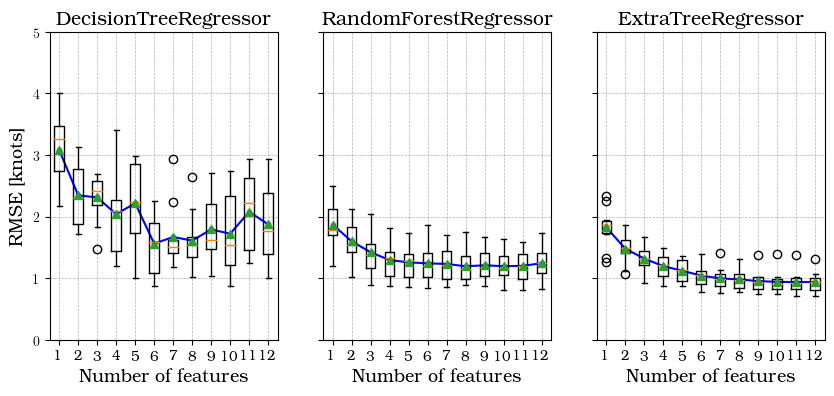

In [169]:
fig, axes = plt.subplots(ncols=3, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
feature_curve(x_test,y_test,regressor='dt',regname='DecisionTreeRegressor')
plt.sca(axes[1])
feature_curve(x_test,y_test,regressor='rf',regname='RandomForestRegressor')
plt.ylabel("")
plt.sca(axes[2])
feature_curve(x_test,y_test,regressor='et',regname='ExtraTreeRegressor')
plt.ylabel("")
plt.show()

Leaf HPO

In [170]:
# Instead , we will invesitagte the effect of setting the minimal samples leaf
def leaf_curve(x,y,regressor,regname):
	from numpy import mean
	from numpy import std
	from sklearn.model_selection import cross_val_score

	plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.sans-serif": "bookman",
	})

	# get a list of models to evaluate
	def get_models_leaf():
		models_leaf = dict()
		# define number of trees to consider
		n_samples_leaf = [1,2,3,4,5,6,7,8,9,10,50]
		for n in n_samples_leaf:
			if regressor == 'dt':
				models_leaf[str(n)] = DecisionTreeRegressor(min_samples_leaf = n)
			if regressor == 'rf':
				models_leaf[str(n)] = RandomForestRegressor(min_samples_leaf = n)
			if regressor == 'et':
				models_leaf[str(n)] = ExtraTreesRegressor(min_samples_leaf = n)
		return models_leaf

	# evaluate a given model using cross-validation
	def evaluate_model(model, x, y):
		scores = cross_val_score(model, x, y, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
		return -scores

	# # define dataset
	# get the models to evaluate
	models_leaf = get_models_leaf()

	# evaluate the models and store results
	results_leaf, names_leaf = list(), list()
	for name, model in models_leaf.items():
		# evaluate the model
		scores_leaf = evaluate_model(model, x, y)
		# store the results
		results_leaf.append(scores_leaf)
		names_leaf.append(name)
		# summarize the performance along the way
		print('>%s %.3f (%.3f)' % (name, mean(scores_leaf), std(scores_leaf)))


	mean_leaf = np.mean(results_leaf,axis=1)
	min_error_leaf = np.min(mean_leaf)
	print(min_error_leaf)
	bst_n_estimators_leaf = np.argmin(mean_leaf)
	print(f"The minimum RMSE obtained is {min_error_leaf:.3f}")
	plt.plot(names_leaf,mean_leaf,"b.-")
	plt.grid(linestyle = '--', linewidth = 0.5)
	# plt.xlim(0,12-1)
	plt.ylim(0,5)
	plt.xlabel(r"Number of Samples in Leaf",fontsize=13)
	plt.ylabel(r"RMSE [knots]",fontsize=13)
	plt.title(rf"{regname}", fontsize=14)
	plt.boxplot(results_leaf, labels=names_leaf,positions=range(len(names_leaf)), showmeans=True)

>1 1.830 (0.536)
>2 1.744 (0.538)
>3 1.632 (0.453)
>4 1.576 (0.360)
>5 1.637 (0.420)
>6 1.640 (0.400)
>7 1.677 (0.394)
>8 1.733 (0.498)
>9 1.706 (0.473)
>10 1.763 (0.420)
>50 2.450 (0.336)
1.5759002605377346
The minimum RMSE obtained is 1.576
>1 1.180 (0.218)
>2 1.172 (0.231)
>3 1.172 (0.208)
>4 1.223 (0.214)
>5 1.250 (0.225)
>6 1.290 (0.222)
>7 1.343 (0.237)
>8 1.361 (0.211)
>9 1.401 (0.205)
>10 1.422 (0.216)
>50 2.354 (0.295)
1.1716344085915469
The minimum RMSE obtained is 1.172
>1 0.938 (0.191)
>2 0.935 (0.182)
>3 0.993 (0.199)
>4 1.097 (0.219)
>5 1.171 (0.243)
>6 1.231 (0.237)
>7 1.289 (0.245)
>8 1.330 (0.240)
>9 1.336 (0.230)
>10 1.384 (0.238)
>50 2.291 (0.393)
0.9351603573551588
The minimum RMSE obtained is 0.935


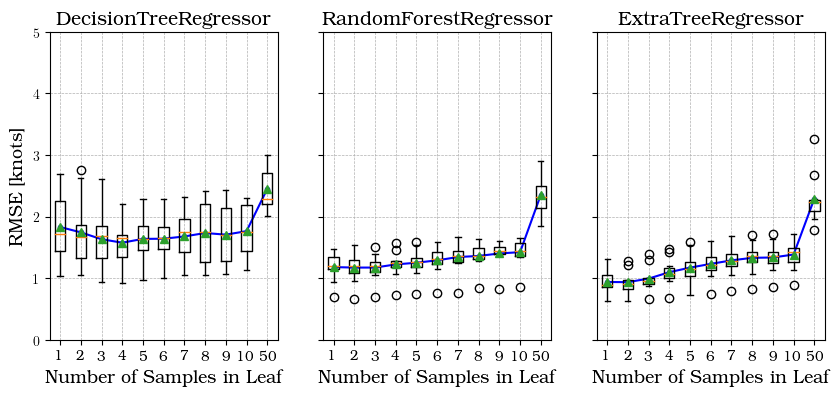

In [171]:
fig, axes = plt.subplots(ncols=3, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
leaf_curve(x_test,y_test,regressor='dt',regname='DecisionTreeRegressor')
plt.sca(axes[1])
leaf_curve(x_test,y_test,regressor='rf',regname='RandomForestRegressor')
plt.ylabel("")
plt.sca(axes[2])
leaf_curve(x_test,y_test,regressor='et',regname='ExtraTreeRegressor')
plt.ylabel("")
plt.show()

Number of Trees HPO (Irrelevant for DT)

In [172]:
# explore random forest and extra tree number of trees effect on performance
def trees_curve(x,y,regressor,regname):
	from numpy import mean
	from numpy import std
	from sklearn.model_selection import cross_val_score

	plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.sans-serif": "bookman",
	})

	# get a list of models to evaluate
	def get_models_tree():
		models_tree = dict()
		# define number of trees to consider
		n_trees = [1,10,100,200,300,400,500,600,700,800,900,1000]
		for n in n_trees:
			if regressor == 'rf':
				models_tree[str(n)] = RandomForestRegressor(n_estimators = n)
			elif regressor == 'et':
				models_tree[str(n)] = ExtraTreesRegressor(n_estimators = n)	
		return models_tree

	# evaluate a given model using cross-validation
	def evaluate_model(model_tree, x, y):
		scores = cross_val_score(model, x, y, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
		return -scores

	# # define dataset
	# get the models to evaluate
	models_tree = get_models_tree()

	# evaluate the models and store results
	results_tree, names_tree = list(), list()
	for name, model in models_tree.items():
		# evaluate the model
		scores_tree = evaluate_model(model, x, y)
		# store the results
		results_tree.append(scores_tree)
		names_tree.append(name)
		# summarize the performance along the way
		print('>%s %.3f (%.3f)' % (name, mean(scores_tree), std(scores_tree)))


	mean_tree = np.mean(results_tree,axis=1)
	min_error_tree = np.min(mean_tree)
	print(min_error_tree)
	print(f"The minimum RMSE obtained is {min_error_tree:.3f}")
	plt.plot(names_tree,mean_tree,"b.-")
	plt.grid(linestyle = '--', linewidth = 0.5)
	# plt.xlim(0,12-1)
	plt.ylim(0,5)
	plt.xlabel(r"Number of Trees", fontsize=13)
	plt.ylabel(r"RMSE [knots]", fontsize=13)
	plt.title(rf"{regname}", fontsize=14)
	pyplot.boxplot(results_tree, labels=names_tree, showmeans=True,positions=range(len(names_tree)))


>1 2.160 (0.408)
>10 1.277 (0.308)
>100 1.198 (0.232)
>200 1.183 (0.234)
>300 1.171 (0.223)
>400 1.190 (0.224)
>500 1.187 (0.226)
>600 1.186 (0.235)
>700 1.184 (0.232)
>800 1.179 (0.227)
>900 1.184 (0.230)
>1000 1.172 (0.227)
1.171241087261839
The minimum RMSE obtained is 1.171
>1 1.573 (0.475)
>10 0.987 (0.178)
>100 0.933 (0.189)
>200 0.940 (0.217)
>300 0.919 (0.198)
>400 0.918 (0.184)
>500 0.917 (0.192)
>600 0.914 (0.187)
>700 0.918 (0.193)
>800 0.920 (0.192)
>900 0.918 (0.191)
>1000 0.922 (0.195)
0.9143871926063927
The minimum RMSE obtained is 0.914


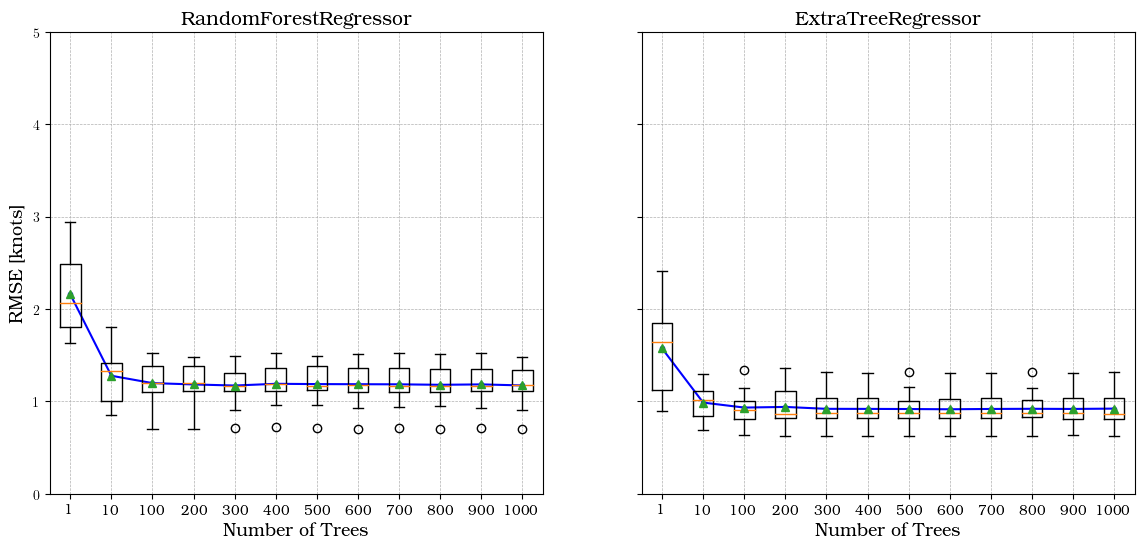

In [173]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6), sharey=True)
plt.sca(axes[0])
trees_curve(x_test,y_test,regressor='rf',regname='RandomForestRegressor')
plt.sca(axes[1])
trees_curve(x_test,y_test,regressor='et',regname='ExtraTreeRegressor')
plt.ylabel("")
plt.show()

Depth HPO

In [174]:
# explore tree based , tree depth. effect on performance
def depth_curve(x,y,regressor,regname):
	from numpy import mean
	from numpy import std
	from sklearn.model_selection import cross_val_score
	from sklearn.model_selection import KFold

	# Parameter to plot in nice latex font

	plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.sans-serif": "bookman",
	})

	# get a list of models to evaluate
	def get_models_dp():
		models_dp = dict()
		# consider tree depths from 1 to 7 and None=full
		depths = [1,2,3,4,5,6,7,8,9,10,100] + [None]
		for n in depths:
			if regressor == 'dt':
				models_dp[str(n)] = DecisionTreeRegressor(max_depth=n)
			elif regressor == 'rf':
				models_dp[str(n)] = RandomForestRegressor(max_depth=n)
			elif regressor == 'et':
				models_dp[str(n)] = ExtraTreesRegressor(max_depth=n)	
		return models_dp

	# evaluate a given model using cross-validation
	def evaluate_model(model, x, y):
		# define the evaluation procedure
		cv = KFold(n_splits=10, shuffle=True, random_state=1)
		# evaluate the model and collect the results
		scores = cross_val_score(model, x, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
		# negative scores due to scoring mechanism of sklearn
		return -scores

	# get the models to evaluate
	models_dp = get_models_dp()
	# evaluate the models and store results
	results_dp, names_dp = list(), list()
	for name, model in models_dp.items():
		# evaluate the model
		scores_dp = evaluate_model(model, x, y)
		# store the results
		results_dp.append(scores_dp)
		names_dp.append(name)
		# summarize the performance along the way
		print('>%s %.3f (%.3f)' % (name, mean(scores_dp), std(scores_dp)))


	mean_dp = np.mean(results_dp,axis=1)
	min_error_dp = np.min(mean_dp)
	print(min_error_dp)
	bst_n_estimators_dp= np.argmin(mean_dp)
	print(f"The minimum RMSE obtained is {min_error_dp:.3f}")
	plt.plot(names_dp,mean_dp,"b.-")
	plt.grid(linestyle = '--', linewidth = 0.5)
	plt.ylim(0,5)
	plt.xlabel(r"Tree Depth",fontsize=13)
	plt.ylabel(r"RMSE [knots]",fontsize=13)
	plt.title(rf"{regname}", fontsize=14)
	plt.boxplot(results_dp, labels=names_dp,positions=range(len(names_dp)), showmeans=True)

>1 3.090 (0.522)
>2 3.055 (0.475)
>3 2.432 (0.530)
>4 2.076 (0.668)
>5 1.949 (0.731)
>6 1.784 (0.713)
>7 1.809 (0.694)
>8 1.870 (0.679)
>9 1.928 (0.671)
>10 1.864 (0.693)
>100 1.856 (0.622)
>None 1.883 (0.638)
1.7836864584689487
The minimum RMSE obtained is 1.784
>1 3.016 (0.510)
>2 2.505 (0.440)
>3 1.858 (0.382)
>4 1.515 (0.332)
>5 1.376 (0.278)
>6 1.283 (0.256)
>7 1.239 (0.256)
>8 1.234 (0.238)
>9 1.250 (0.270)
>10 1.219 (0.231)
>100 1.237 (0.242)
>None 1.252 (0.245)
1.2190705993613904
The minimum RMSE obtained is 1.219
>1 3.040 (0.565)
>2 2.303 (0.390)
>3 1.727 (0.247)
>4 1.371 (0.226)
>5 1.192 (0.211)
>6 1.077 (0.195)
>7 1.030 (0.181)
>8 0.985 (0.188)
>9 0.964 (0.202)
>10 0.926 (0.163)
>100 0.938 (0.176)
>None 0.937 (0.186)
0.9264951355872398
The minimum RMSE obtained is 0.926


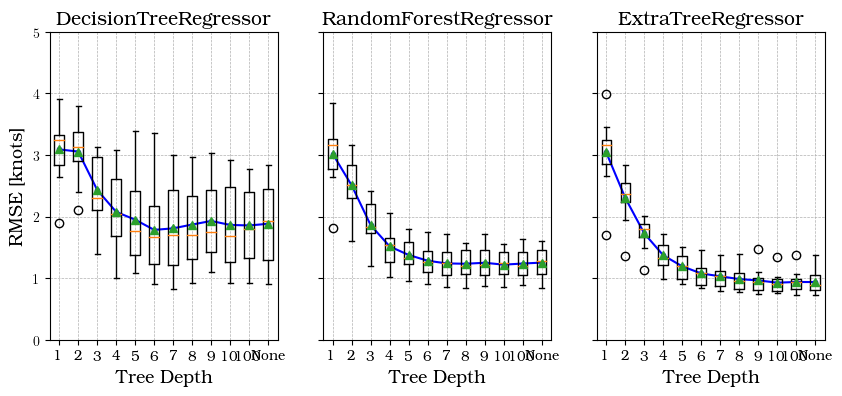

In [175]:
fig, axes = plt.subplots(ncols=3, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
depth_curve(x_test,y_test,regressor='dt',regname='DecisionTreeRegressor')
plt.sca(axes[1])
depth_curve(x_test,y_test,regressor='rf',regname='RandomForestRegressor')
plt.ylabel("")
plt.sca(axes[2])
depth_curve(x_test,y_test,regressor='et',regname='ExtraTreeRegressor')
plt.ylabel("")
plt.show()

Min sample split HPO

In [176]:
# explore tree based , tree depth. effect on performance
def split_curve(x,y,regressor,regname):
	from numpy import mean
	from numpy import std
	from sklearn.model_selection import cross_val_score
	from sklearn.model_selection import KFold

	# Parameter to plot in nice latex font

	plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.sans-serif": "bookman",
	})

	# get a list of models to evaluate
	def get_models_sp():
		models_sp = dict()
		# consider tree depths from 1 to 7 and None=full
		split = [1,2,3,4,5,6,7,8,9,10,50,100]
		for n in split:
			if regressor == 'dt':
				models_sp[str(n)] = DecisionTreeRegressor(max_depth=n)
			elif regressor == 'rf':
				models_sp[str(n)] = RandomForestRegressor(max_depth=n)
			elif regressor == 'et':
				models_sp[str(n)] = ExtraTreesRegressor(max_depth=n)	
		return models_sp

	# evaluate a given model using cross-validation
	def evaluate_model(model, x, y):
		# define the evaluation procedure
		cv = KFold(n_splits=10, shuffle=True, random_state=1)
		# evaluate the model and collect the results
		scores = cross_val_score(model, x, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
		# negative scores due to scoring mechanism of sklearn
		return -scores

	# get the models to evaluate
	models_sp = get_models_sp()
	# evaluate the models and store results
	results_sp, names_sp = list(), list()
	for name, model in models_sp.items():
		# evaluate the model
		scores_sp = evaluate_model(model, x, y)
		# store the results
		results_sp.append(scores_sp)
		names_sp.append(name)
		# summarize the performance along the way
		print('>%s %.3f (%.3f)' % (name, mean(scores_sp), std(scores_sp)))


	mean_sp = np.mean(results_sp,axis=1)
	min_error_sp = np.min(mean_sp)
	print(min_error_sp)
	bst_n_estimators_sp= np.argmin(mean_sp)
	print(f"The minimum RMSE obtained is {min_error_sp:.3f}")
	plt.plot(names_sp,mean_sp,"b.-")
	plt.grid(linestyle = '--', linewidth = 0.5)
	plt.ylim(0,5)
	plt.xlabel(r"Minimum Sample to split ",fontsize=13)
	plt.ylabel(r"RMSE [knots]",fontsize=13)
	plt.title(rf"{regname}", fontsize=14)
	plt.boxplot(results_sp, labels=names_sp,positions=range(len(names_sp)), showmeans=True)

>1 3.090 (0.522)
>2 3.055 (0.475)
>3 2.432 (0.530)
>4 2.171 (0.593)
>5 1.940 (0.610)
>6 1.886 (0.751)
>7 1.799 (0.657)
>8 1.864 (0.585)
>9 1.856 (0.720)
>10 1.869 (0.686)
>50 1.854 (0.665)
>100 1.868 (0.621)
1.7986000857522413
The minimum RMSE obtained is 1.799
>1 3.019 (0.514)
>2 2.499 (0.424)
>3 1.818 (0.373)
>4 1.529 (0.331)
>5 1.366 (0.302)
>6 1.295 (0.240)
>7 1.267 (0.253)
>8 1.256 (0.257)
>9 1.258 (0.256)
>10 1.233 (0.252)
>50 1.233 (0.250)
>100 1.238 (0.248)
1.2331318395532924
The minimum RMSE obtained is 1.233
>1 3.043 (0.568)
>2 2.310 (0.385)
>3 1.713 (0.247)
>4 1.346 (0.215)
>5 1.182 (0.206)
>6 1.087 (0.192)
>7 1.028 (0.193)
>8 0.975 (0.177)
>9 0.960 (0.175)
>10 0.949 (0.184)
>50 0.929 (0.188)
>100 0.923 (0.198)
0.9229665581883726
The minimum RMSE obtained is 0.923


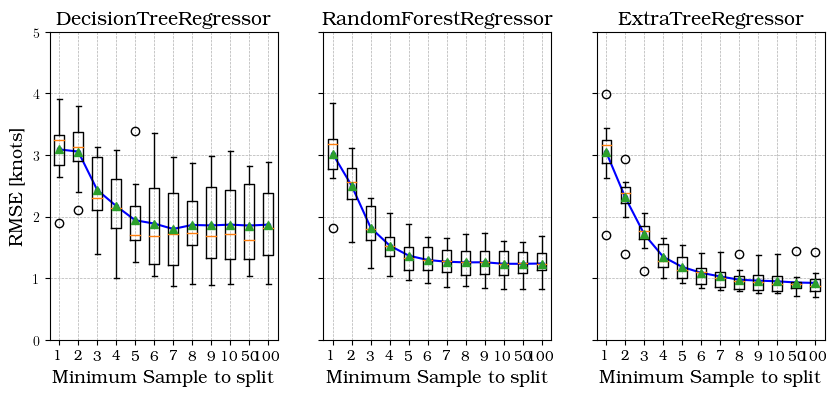

In [177]:
fig, axes = plt.subplots(ncols=3, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
split_curve(x_test,y_test,regressor='dt',regname='DecisionTreeRegressor')
plt.sca(axes[1])
split_curve(x_test,y_test,regressor='rf',regname='RandomForestRegressor')
plt.ylabel("")
plt.sca(axes[2])
split_curve(x_test,y_test,regressor='et',regname='ExtraTreeRegressor')
plt.ylabel("")
plt.show()

In [ ]:
stop

In [178]:
from pprint import pprint
pprint(model_rfr_ftr.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [179]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [100,200,300,400,500,600,700,800,900,1000]
# Number of features to consider at every split
max_features = [6,7,8,9,10,11,12]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3,4,5,6,7,8,9,10]
# Method of selecting samples for training each tree
# bootstrap = [True]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
pprint(random_grid)

{'max_depth': [10,
               20,
               30,
               40,
               50,
               60,
               70,
               80,
               90,
               100,
               110,
               120,
               130,
               140,
               150,
               160,
               170,
               180,
               190,
               200,
               None],
 'max_features': [6, 7, 8, 9, 10, 11, 12],
 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [180]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = model_rfr_ftr, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42,n_jobs=-1)# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110, 120,
                                                      130, 140, 150, 160, 170,
                                                      180, 190, 200, None],
                                        'max_features': [6, 7, 8, 9, 10, 11,
                                                         12],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, verbose=2)

In [181]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 10,
 'max_depth': 120}

In [182]:
def evaluate(model, test_features, test_labels):
    from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error

    predictions = model.predict(test_features)
    rsquared = model.score(test_features,test_labels)
    expVar = explained_variance_score(test_labels,predictions)
    MAE = mean_absolute_error(test_labels,predictions)
    MAD = median_absolute_error(test_labels,predictions)
    RMSE = np.sqrt(mean_squared_error(test_labels,predictions))

    print(f"Model Performance of {model}")
    print(f"R^2: {rsquared:0.4f}")
    print(f"explained Variance = {expVar:0.4f}")
    print(f"MAE = {MAE:0.4f}")
    print(f"RMSE = {RMSE:0.4f}")
    print(f"MAD = {MAD:0.4f}\n")
    
    return rsquared,expVar,MAE,RMSE,MAD

base_model = model_rfr_ftr
base_model.fit(x_train, y_train)
rsquared_base,expVar_base,MAE_base,RMSE_base,MAD_base = evaluate(base_model, x_test, y_test)

best_random = rf_random.best_estimator_
rsquared_random,expVar_random,MAE_random,RMSE_random,MAD_random = evaluate(best_random, x_test, y_test)
print('Improvement of Rsquared {:0.3f}%.'.format( 100 * (rsquared_random - rsquared_base) / rsquared_base))
print('Improvement of explainedVariance {:0.3f}%.'.format( 100 * (expVar_random - expVar_base) / expVar_base))
print('Improvement of MAE {:0.3f}%.'.format( 100 * (MAE_base - MAE_random) / MAE_base)) # MAE is other way around since best score is 0
print('Improvement of RMSE {:0.3f}%.'.format( 100 * (RMSE_base - RMSE_random) / RMSE_base)) # RMSE is other way around since best score is 0
print('Improvement of MAD {:0.3f}%.'.format( 100 * (MAD_base - MAD_random) / MAD_base)) # MAD is other way around since best score is 0

Model Performance of RandomForestRegressor(random_state=42)
R^2: 0.9340
explained Variance = 0.9341
MAE = 0.5560
RMSE = 0.8346
MAD = 0.3949

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2: 0.9324
explained Variance = 0.9324
MAE = 0.5572
RMSE = 0.8449
MAD = 0.3828

Improvement of Rsquared -0.174%.
Improvement of explainedVariance -0.174%.
Improvement of MAE -0.212%.
Improvement of RMSE -1.228%.
Improvement of MAD 3.066%.


HPO for DTR test data

In [183]:
# Number of trees in random forest
# Number of features to consider at every split
max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# Maximum number of levels in tree
max_depth = [1,2,3,4,5,6,7,8,9,10,100]
max_depth.append(None)
# max_depth = [None]
# Minimum number of samples required to split a node
min_samples_split = [2, 3,4,5,6,7,8,9,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,3,4,5,6,7,8,9,10]
random_grid_dtr = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,}
pprint(random_grid_dtr)

{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100, None],
 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12],
 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]}


In [184]:
dt_random = RandomizedSearchCV(estimator = model_dtr, param_distributions = random_grid_dtr, n_iter = 100, cv = 5, verbose=2, random_state=42,n_jobs=-1)# Fit the dt search model
dt_random.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 100, None],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 12],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10]},
                   random_state=42, verbose=2)

In [185]:
dt_random.best_params_

{'min_samples_split': 7,
 'min_samples_leaf': 10,
 'max_features': 12,
 'max_depth': 8}

In [186]:
base_model = model_dtr
base_model.fit(x_train, y_train)
rsquared_base,expVar_base,MAE_base,RMSE_base,MAD_base = evaluate(base_model, x_test, y_test)

best_random = dt_random.best_estimator_
rsquared_random,expVar_random,MAE_random,RMSE_base,MAD_random = evaluate(best_random, x_test, y_test)
print('Improvement of Rsquared {:0.3f}%.'.format( 100 * (rsquared_random - rsquared_base) / rsquared_base))
print('Improvement of explainedVariance {:0.3f}%.'.format( 100 * (expVar_random - expVar_base) / expVar_base))
print('Improvement of MAE {:0.3f}%.'.format( 100 * (MAE_base - MAE_random) / MAE_base)) # MAE is other way around since best score is 0
print('Improvement of RMSE {:0.3f}%.'.format( 100 * (RMSE_base - RMSE_random) / RMSE_base)) # RMSE is other way around since best score is 0
print('Improvement of MAD {:0.3f}%.'.format( 100 * (MAD_base - MAD_random) / MAD_base)) # MAD is other way around since best score is 0

Model Performance of DecisionTreeRegressor()
R^2: 0.8320
explained Variance = 0.8320
MAE = 0.8405
RMSE = 1.3321
MAD = 0.5801

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2: 0.9012
explained Variance = 0.9013
MAE = 0.6688
RMSE = 1.0216
MAD = 0.4389

Improvement of Rsquared 8.318%.
Improvement of explainedVariance 8.323%.
Improvement of MAE 20.430%.
Improvement of RMSE 17.295%.
Improvement of MAD 24.332%.


ETR

In [187]:
from pprint import pprint
pprint(model_etr.get_params())

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [188]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [100,200,300,400,500,600,700,800,900,1000]
# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [1,2,3,4,5,6,7,8,9,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3,4,5,6,7,8,9,10]
# Method of selecting samples for training each tree
# bootstrap = [True]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
               #'bootstrap': bootstrap}
pprint(random_grid)

{'max_depth': [10,
               20,
               30,
               40,
               50,
               60,
               70,
               80,
               90,
               100,
               110,
               120,
               130,
               140,
               150,
               160,
               170,
               180,
               190,
               200,
               None],
 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12],
 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [189]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
et_random = RandomizedSearchCV(estimator = model_etr, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=1,n_jobs=-1)# Fit the random search model
et_random.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\Wafi\anaconda3\envs\geron1\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
75 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Wafi\anaconda3\envs\geron1\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Wafi\anaconda3\envs\geron1\lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "c:\Users\Wafi\anaconda3\envs\geron1\lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  Fi

RandomizedSearchCV(cv=5, estimator=ExtraTreesRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110, 120,
                                                      130, 140, 150, 160, 170,
                                                      180, 190, 200, None],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 12],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_samples_split': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=1, verbose=2)

In [190]:
et_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 9,
 'min_samples_leaf': 1,
 'max_features': 12,
 'max_depth': 120}

In [191]:
def evaluate(model, test_features, test_labels):
    from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error

    predictions = model.predict(test_features)
    rsquared = model.score(test_features,test_labels)
    expVar = explained_variance_score(test_labels,predictions)
    MAE = mean_absolute_error(test_labels,predictions)
    MAD = median_absolute_error(test_labels,predictions)
    RMSE = np.sqrt(mean_squared_error(test_labels,predictions))

    print(f"Model Performance of {model}")
    print(f"R^2: {rsquared:0.4f}")
    print(f"explained Variance = {expVar:0.4f}")
    print(f"MAE = {MAE:0.4f}")
    print(f"RMSE = {RMSE:0.4f}")
    print(f"MAD = {MAD:0.4f}\n")
    
    return rsquared,expVar,MAE,RMSE,MAD

base_model = model_etr
base_model.fit(x_train, y_train)
rsquared_base,expVar_base,MAE_base,RMSE_base,MAD_base = evaluate(base_model, x_test, y_test)

best_random = rf_random.best_estimator_
rsquared_random,expVar_random,MAE_random,RMSE_random,MAD_random = evaluate(best_random, x_test, y_test)
print('Improvement of Rsquared {:0.3f}%.'.format( 100 * (rsquared_random - rsquared_base) / rsquared_base))
print('Improvement of explainedVariance {:0.3f}%.'.format( 100 * (expVar_random - expVar_base) / expVar_base))
print('Improvement of MAE {:0.3f}%.'.format( 100 * (MAE_base - MAE_random) / MAE_base)) # MAE is other way around since best score is 0
print('Improvement of RMSE {:0.3f}%.'.format( 100 * (RMSE_base - RMSE_random) / RMSE_base)) # RMSE is other way around since best score is 0
print('Improvement of MAD {:0.3f}%.'.format( 100 * (MAD_base - MAD_random) / MAD_base)) # MAD is other way around since best score is 0

Model Performance of ExtraTreesRegressor(random_state=42)
R^2: 0.9365
explained Variance = 0.9366
MAE = 0.5332
RMSE = 0.8188
MAD = 0.3772

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2: 0.9324
explained Variance = 0.9324
MAE = 0.5572
RMSE = 0.8449
MAD = 0.3828

Improvement of Rsquared -0.439%.
Improvement of explainedVariance -0.445%.
Improvement of MAE -4.499%.
Improvement of RMSE -3.185%.
Improvement of MAD -1.484%.


HPO for validation data 

In [192]:
dfdate6 = dfdate6.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)
dfdate6.head(n=5)

,Temperature above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,Combined wind waves and swell height,Swell height,Wind wave height,Draught,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,True North Wind Direction,True North Current Direction,Current Speed,Wind Speed
119,275.823975,3.358080,6.738089,4.925452,5.291555,278.661621,1.759765,0.743164,1.583740,5.281861,...,100.782313,100.989288,164.871808,15.554049,66.843493,57.268527,21.771601,184.345879,0.144914,10.248966
120,275.924011,3.578120,7.185143,5.342444,5.697814,278.936035,1.950242,0.841925,1.757568,5.289403,...,96.934816,108.737155,153.650411,11.071672,60.455881,51.313932,25.671971,199.414773,0.246220,11.364678
121,276.285034,4.184914,7.260825,5.460486,6.126474,279.209961,2.189788,0.933936,1.910706,5.288446,...,97.525758,114.910729,153.031589,16.281358,57.086511,46.894106,32.436488,199.442652,0.284315,12.666946
122,277.189484,4.908680,6.808745,6.225745,6.284671,279.216553,2.565230,0.723303,2.452637,5.290781,...,106.941521,123.568984,153.643227,69.175152,55.507286,56.527939,50.510505,189.415252,0.300428,13.386999
126,277.408752,4.621826,6.813305,5.970984,6.291378,279.319824,2.414834,1.022894,2.130981,4.842367,...,227.680837,26.476633,41.766758,158.632374,159.050718,167.192888,74.157471,180.552404,0.262897,12.053293


In [193]:
dfdate6= dfdate6.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [194]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)

In [195]:
dfdate6 = dfdate6[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]


In [196]:
imputer.fit(dfdate6)

KNNImputer(n_neighbors=50)

In [197]:
xdate = imputer.transform(dfdate6)

In [198]:
dfdate6tr = pd.DataFrame(xdate, columns=dfdate6.columns, index=dfdate6.index)

In [199]:
# x_date = dfdate6tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
# y_date = dfdate6tr.sog

x_date = dfdate6tr.drop(['sog','truewinddir','truecurrentdir'],axis=1)
y_date = dfdate6tr.sog

ETR HPO Validation Data

In [200]:
# from pprint import pprint
# pprint(model_etr.get_params())

In [201]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [100,200,300,400,500,600,700,800,900,1000]
# # n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# # Number of features to consider at every split
# max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
# max_depth.append(None)
# # max_depth = [None]
# # Minimum number of samples required to split a node
# min_samples_split = [1,2,3,4,5,6,7,8,9,10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 3,4,5,6,7,8,9,10]
# # Method of selecting samples for training each tree
# # bootstrap = [True]# Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                #'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf}
#                #'bootstrap': bootstrap}
# pprint(random_grid)

In [202]:
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# etr_random = RandomizedSearchCV(estimator = model_etr, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=1,n_jobs=-1)# Fit the random search model
# etr_random.fit(x_date, y_date)

In [203]:
# def evaluate(model, test_features, test_labels):
#     from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error

#     predictions = model.predict(test_features)
#     rsquared = model.score(test_features,test_labels)
#     expVar = explained_variance_score(test_labels,predictions)
#     MAE = mean_absolute_error(test_labels,predictions)
#     MAD = median_absolute_error(test_labels,predictions)
#     RMSE = np.sqrt(mean_squared_error(test_labels,predictions))

#     print(f"Model Performance of {model}")
#     print(f"R^2: {rsquared:0.4f}")
#     print(f"explained Variance = {expVar:0.4f}")
#     print(f"MAE = {MAE:0.4f}")
#     print(f"RMSE = {RMSE:0.4f}")
#     print(f"MAD = {MAD:0.4f}\n")
    
#     return rsquared,expVar,MAE,RMSE,MAD
# base_model = model_etr
# base_model.fit(x_train, y_train)
# rsquared_base,expVar_base,MAE_base,RMSE_base,MAD_base = evaluate(base_model, x_date, y_date)

# etr_best_random = etr_random.best_estimator_
# rsquared_random,expVar_random,MAE_random,RMSE_random,MAD_random = evaluate(etr_best_random, x_date, y_date)
# print('Improvement of Rsquared {:0.3f}%.'.format( 100 * (rsquared_random - rsquared_base) / rsquared_base))
# print('Improvement of explainedVariance {:0.3f}%.'.format( 100 * (expVar_random - expVar_base) / expVar_base))
# print('Improvement of MAE {:0.3f}%.'.format( 100 * (MAE_base - MAE_random) / MAE_base)) # MAE is other way around since best score is 0
# print('Improvement of RMSE {:0.3f}%.'.format( 100 * (RMSE_base - RMSE_random) / RMSE_base)) # RMSE is other way around since best score is 0
# print('Improvement of MAD {:0.3f}%.'.format( 100 * (MAD_base - MAD_random) / MAD_base)) # MAD is other way around since best score is 0

RFR HPO Validation

In [204]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [100,200,300,400,500,600,700,800,900,1000]
# # n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# # Number of features to consider at every split
# max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
# max_depth.append(None)
# # max_depth = [None]
# # Minimum number of samples required to split a node
# min_samples_split = [1,2,3,4,5,6,7,8,9,10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 3,4,5,6,7,8,9,10]
# # Method of selecting samples for training each tree
# # bootstrap = [True]# Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                #'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf}
#                #'bootstrap': bootstrap}
# pprint(random_grid)

In [205]:
# rf_random = RandomizedSearchCV(estimator = model_rfr_ftr, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42,n_jobs=-1)# Fit the random search model
# rf_random.fit(x_date, y_date)

In [206]:
# rf_random.best_params_

In [207]:
# def evaluate(model, test_features, test_labels):
#     from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error

#     predictions = model.predict(test_features)
#     rsquared = model.score(test_features,test_labels)
#     expVar = explained_variance_score(test_labels,predictions)
#     MAE = mean_absolute_error(test_labels,predictions)
#     MAD = median_absolute_error(test_labels,predictions)
#     RMSE = np.sqrt(mean_squared_error(test_labels,predictions))

#     print(f"Model Performance of {model}")
#     print(f"R^2: {rsquared:0.4f}")
#     print(f"explained Variance = {expVar:0.4f}")
#     print(f"MAE = {MAE:0.4f}")
#     print(f"RMSE = {RMSE:0.4f}")
#     print(f"MAD = {MAD:0.4f}\n")
    
#     return rsquared,expVar,MAE,RMSE,MAD

# base_model = model_rfr_ftr
# base_model.fit(x_date, y_date)
# rsquared_base,expVar_base,MAE_base,RMSE_base,MAD_base = evaluate(base_model, x_date, y_date)

# best_random = rf_random.best_estimator_
# # best_random = model_rfr_ftr_hpov
# rsquared_random,expVar_random,MAE_random,RMSE_random,MAD_random = evaluate(best_random, x_date, y_date)
# print('Improvement of Rsquared {:0.3f}%.'.format( 100 * (rsquared_random - rsquared_base) / rsquared_base))
# print('Improvement of explainedVariance {:0.3f}%.'.format( 100 * (expVar_random - expVar_base) / expVar_base))
# print('Improvement of MAE {:0.3f}%.'.format( 100 * (MAE_base - MAE_random) / MAE_base)) # MAE is other way around since best score is 0
# print('Improvement of RMSE {:0.3f}%.'.format( 100 * (RMSE_base - RMSE_random) / RMSE_base)) # RMSE is other way around since best score is 0
# print('Improvement of MAD {:0.3f}%.'.format( 100 * (MAD_base - MAD_random) / MAD_base)) # MAD is other way around since best score is 0

DTR HPO Validation data 

In [208]:
# # Number of trees in random forest
# # Number of features to consider at every split
# max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
# max_depth.append(None)
# # max_depth = [None]
# # Minimum number of samples required to split a node
# min_samples_split = [1,2,3,4, 5,6,7,8,9, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2,3,4,5,6,7,8,9,10]
# random_grid_dtr = {'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,}
# pprint(random_grid_dtr)

In [209]:
# dt_random = RandomizedSearchCV(estimator = model_dtr, param_distributions = random_grid_dtr, n_iter = 100, cv = 5, verbose=2, random_state=42,n_jobs=-1)# Fit the dt search model
# dt_random.fit(x_date, y_date)

In [210]:
# dt_random.best_params_

In [211]:
# base_model = model_dtr
# base_model.fit(x_train, y_train)
# rsquared_base,expVar_base,MAE_base,RMSE_base,MAD_base = evaluate(base_model, x_date, y_date)

# best_random = dt_random.best_estimator_
# rsquared_random,expVar_random,MAE_random,RMSE_base,MAD_random = evaluate(best_random, x_date, y_date)
# print('Improvement of Rsquared {:0.3f}%.'.format( 100 * (rsquared_random - rsquared_base) / rsquared_base))
# print('Improvement of explainedVariance {:0.3f}%.'.format( 100 * (expVar_random - expVar_base) / expVar_base))
# print('Improvement of MAE {:0.3f}%.'.format( 100 * (MAE_base - MAE_random) / MAE_base)) # MAE is other way around since best score is 0
# print('Improvement of RMSE {:0.3f}%.'.format( 100 * (RMSE_base - RMSE_random) / RMSE_base)) # RMSE is other way around since best score is 0
# print('Improvement of MAD {:0.3f}%.'.format( 100 * (MAD_base - MAD_random) / MAD_base)) # MAD is other way around since best score is 0

In [212]:
# print(dt_random.best_estimator_)